# Delineate Watersheds and write shapefile
## Does not include step by step figures

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from shapely import geometry, ops
import fiona
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
from matplotlib.ticker import ScalarFormatter
from shapely.geometry import Point
%matplotlib inline

## Instatiate a grid

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
q01_x,q01_y = -119.26139, 37.77778 #lyell Fork Below Maclure
q02_x,q02_y = -119.3311, 37.869 #Lyell Fk. Tuolumne R. at Twin Bridges
q03_x,q03_y = -119.338, 37.877 #Dana Fk. Tuolumne R. at Bug Camp
q04_x,q04_y = -119.35475, 37.87629 # Tuolumne R. at Highway 120
q05_x,q05_y = -119.381056, 37.883357 # Delaney Cr. At Tuolumne Meadows
q06_x,q06_y = -119.382, 37.873 # Budd Cr. At Tuolumne Meadows brian henn paper
point_x, point_y = -119.7879546, 37.9476989 # outlet
budd_x,budd_y = -119.38418,37.87594

#q06_x,q06_y = -119.873, 37.89489 # Budd Cr. At Tuolumne Meadows readme files dont use

In [3]:
# Instatiate a grid from a raster
demdir = '/home/etboud/projects/data/cop_DEM/mosaic'
id = 'mosaic_output'
dem_fn = os.path.join(demdir, id+'.tif')
grid = Grid.from_raster(dem_fn, data_name='dem')
dem = grid.read_raster(dem_fn, data_name='dem')

# Specify flow direction values

In [4]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Clip to a smaller area

In [5]:
# not from notebook but tryng to figure out errors
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# not from this notebook trying to figure out errors
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

#Calculate flow accumulation
#--------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

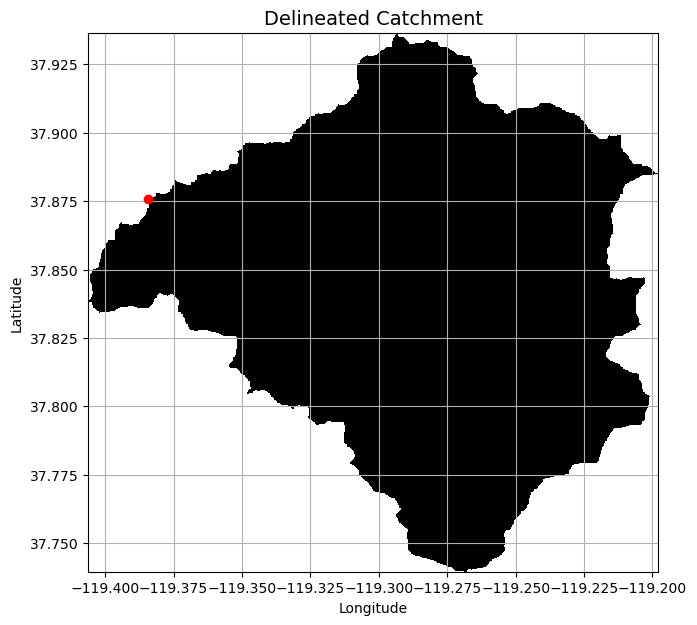

In [6]:
# Snap pour point to high accumulation cell

x,y = budd_x,budd_y

x_snap, y_snap = grid.snap_to_mask(acc > 20000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)




# Plot the catchment
fig, ax = plt.subplots(figsize=(9,7))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
            zorder=1, cmap='Greys_r')
plt.scatter(x, y, color='red', label='Your Point', zorder=2)
plt.xlim(grid.extent[:2])
plt.ylim(grid.extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Create vector representation of catchment mask

In [7]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Write to shapefile

In [8]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('budd.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

# Read created shapefile

In [9]:
shp = gpd.read_file('tuolumne.shp')

# Inspect created shapefile

In [10]:
shp

,LABEL,geometry
0,1,"POLYGON ((-119.29375 37.93653, -119.29292 37.9..."


Text(0.5, 1.0, 'Catchment polygon')

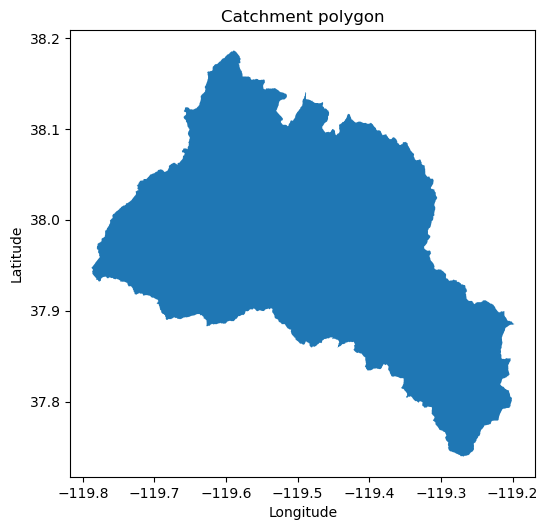

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

# Write river network to shapefile

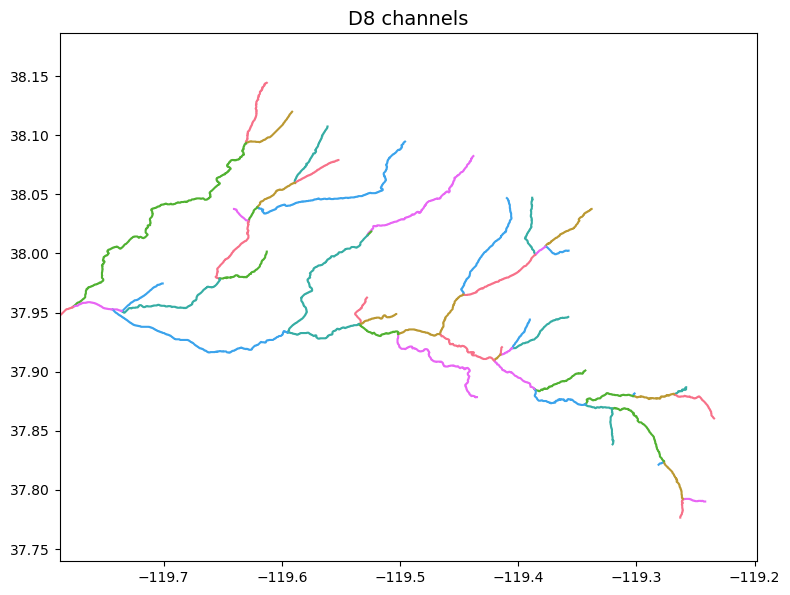

In [18]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 15000, dirmap=dirmap)
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(9,7))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

In [19]:
schema = {
    'geometry': 'LineString',
    'properties': {}
}

with fiona.open('tuo_rivers.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for branch in branches['features']:
        rec = {}
        rec['geometry'] = branch['geometry']
        rec['properties'] = {}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

# Read created shapefile

In [21]:
shp = gpd.read_file('tuo_rivers.shp')

# Inspect created shapefile

In [ ]:
shp.head()

Text(0.5, 1.0, 'River network')

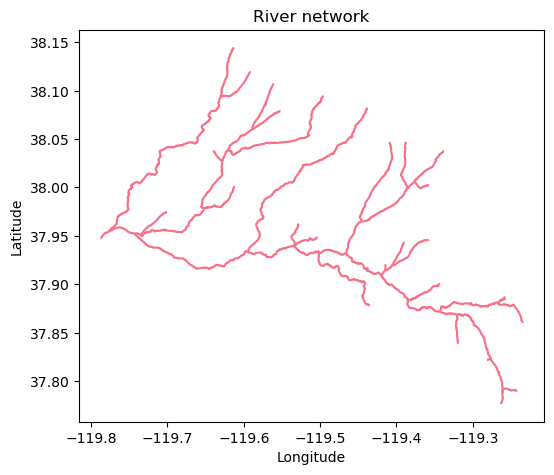

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network')

### To GEOJSON

In [1]:
import glob
import geopandas as gpd
from shapely.geometry import Polygon

dir = '/home/etboud/projects/data/shp_out/'
fn_list = glob.glob(dir + "*.shp")

for fn in fn_list:
    # Extract file ID
    ID = fn.split("/")[-1].split(".")[0]

    # Read GeoDataFrame from file
    ID_gdf = gpd.read_file(fn)

    # Correct polygons to be in union
    union_geometry = ID_gdf.geometry.unary_union

    # Create GeoSeries from union to convert back to GeoDataFrame
    union_series = gpd.GeoSeries([union_geometry])

    # Create GeoDataFrame for the union
    union_gdf = gpd.GeoDataFrame(geometry=union_series, crs=ID_gdf.crs)
    locals()[f"{ID}_union_gdf"]=union_gdf

In [ ]:
# convert shp file to geojson
budd_union_gdf.to_file('budd_unclip.geojson', driver='GeoJSON')